In [29]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
train_emb_path = '/content/roberta_embeddings_train.pkl'
test_emb_path = '/content/roberta_embeddings_test.pkl'
train_labels_path = '/content/incidents_train_clean_excel.xlsx'
test_labels_path = '/content/incidents_test_clean_excel.xlsx'

In [4]:
def load_embeddings(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [5]:
X = load_embeddings(train_emb_path)

In [7]:
X_embed = np.array([np.array(emb, dtype=np.float32) for emb in X])


In [8]:
# --- Load the labels ---
X_label = pd.read_excel(train_labels_path)


In [9]:
X_label["hazard-category"].unique()

array(['biological', 'foreign bodies', 'chemical', 'fraud',
       'organoleptic aspects', 'allergens', 'packaging defect',
       'other hazard', 'food additives and flavourings', nan, ' PE',
       'migration'], dtype=object)

In [10]:
X_embed.shape

(5084, 1024)

**Hazard-category**

In [11]:
X_labels = X_label["hazard-category"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, X_labels, test_size=0.2, random_state=42)


In [13]:
# Now X_train, y_train, X_test, y_test are ready
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (4067, 1024) (4067,)
Test shape: (1017, 1024) (1017,)


In [14]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [15]:
# Now X_train, y_train, X_test, y_test are ready
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (4067, 1024) (4067,)
Test shape: (1017, 1024) (1017,)


In [16]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


In [17]:
train_dataset = EmbeddingDataset(X_train, y_train)
test_dataset = EmbeddingDataset(X_test, y_test)


In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [215]:
class LSTMTextClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_size=1024, num_classes=12, num_layers=1, dropout=0.8):
        super(LSTMTextClassifier, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer to map the output of the LSTM to the desired number of classes
        self.fc = nn.Linear(hidden_size, num_classes)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Pass through LSTM
        lstm_out, (hn, cn) = self.lstm(x)

        # Use the output from the last time step (you could experiment with using all time steps as well)
        out = lstm_out[:, -1, :]  # Take the last output

        # Apply dropout
        out = self.dropout(out)

        # Pass through the fully connected layer
        out = self.fc(out)

        return out




In [216]:
# Model initialization
model = LSTMTextClassifier()

# Loss function (CrossEntropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training loop
epochs = 100  # Set the number of epochs

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn(


LSTMTextClassifier(
  (lstm): LSTM(1024, 1024, batch_first=True, dropout=0.8)
  (fc): Linear(in_features=1024, out_features=12, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [217]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Print the total number of parameters
print(f"Total number of parameters: {count_parameters(model)}")

Total number of parameters: 8409100


In [218]:
train_losses = []
test_losses = []

In [219]:
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Add a dummy sequence length for LSTM input: (batch_size, seq_len=1, input_size)
        inputs = inputs.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔁 Evaluate on test data **within each epoch**
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")





Epoch [1/100], Train Loss: 1.6151, Test Loss: 1.4852
Epoch [2/100], Train Loss: 1.4424, Test Loss: 1.3182
Epoch [3/100], Train Loss: 1.3059, Test Loss: 1.2125
Epoch [4/100], Train Loss: 1.1799, Test Loss: 1.0770
Epoch [5/100], Train Loss: 1.0958, Test Loss: 1.0094
Epoch [6/100], Train Loss: 1.0261, Test Loss: 0.9577
Epoch [7/100], Train Loss: 1.0083, Test Loss: 0.9077
Epoch [8/100], Train Loss: 0.9607, Test Loss: 0.8833
Epoch [9/100], Train Loss: 0.9365, Test Loss: 0.8598
Epoch [10/100], Train Loss: 0.9240, Test Loss: 0.8595
Epoch [11/100], Train Loss: 0.8984, Test Loss: 0.8502
Epoch [12/100], Train Loss: 0.8570, Test Loss: 0.8019
Epoch [13/100], Train Loss: 0.8516, Test Loss: 0.7893
Epoch [14/100], Train Loss: 0.8294, Test Loss: 0.7728
Epoch [15/100], Train Loss: 0.8095, Test Loss: 0.7671
Epoch [16/100], Train Loss: 0.7969, Test Loss: 0.7706
Epoch [17/100], Train Loss: 0.7920, Test Loss: 0.7533
Epoch [18/100], Train Loss: 0.7619, Test Loss: 0.7677
Epoch [19/100], Train Loss: 0.7910, T

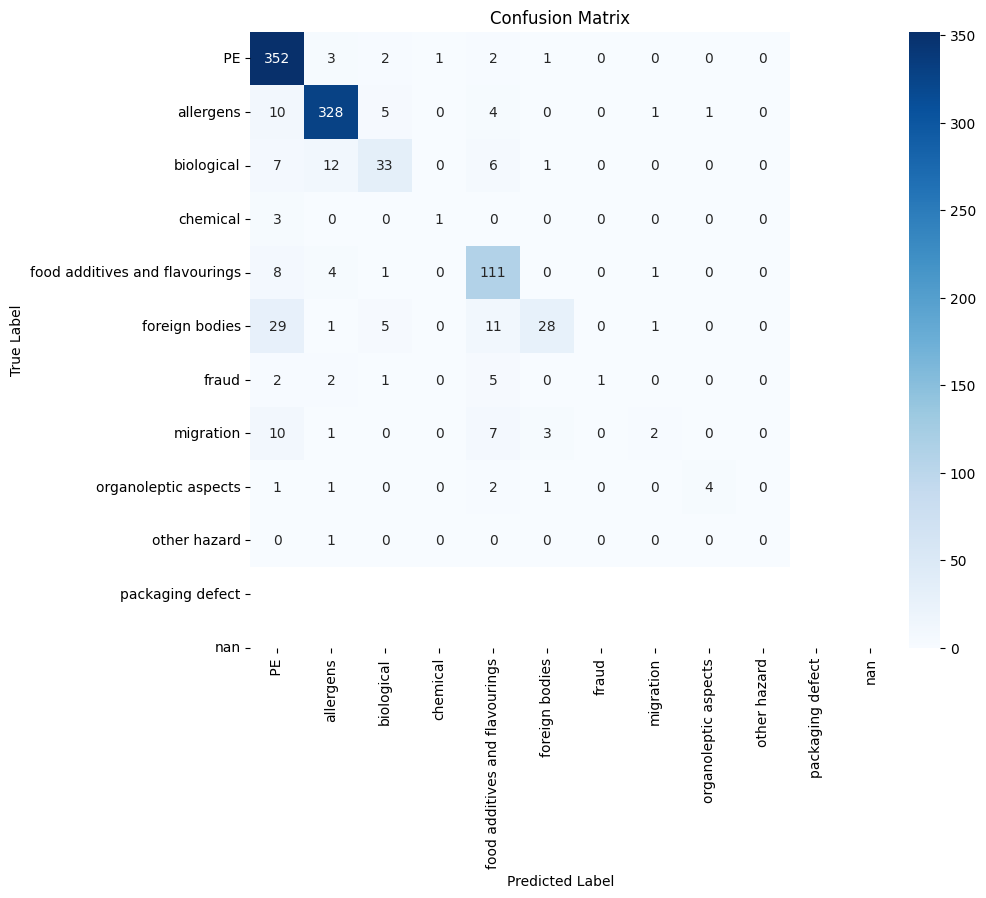

In [220]:
cm = confusion_matrix(all_labels, all_preds)
# Plot it once
plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("confusion_matrix.png")
plt.show()


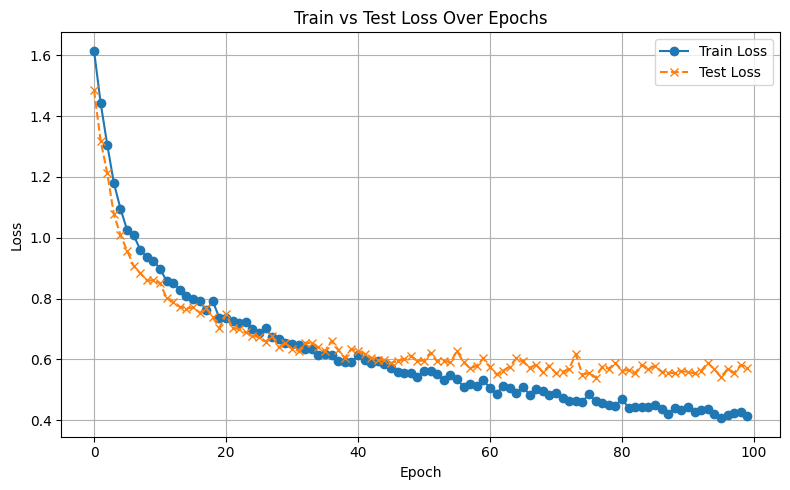

In [221]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(test_losses, label='Test Loss', marker='x', linestyle='--')
plt.title("Train vs Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [222]:
# Convert lists to numpy arrays for sklearn functions
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
num_classes=12

precision_macro = precision_score(all_labels, all_preds, average='macro', labels=np.arange(num_classes))
recall_macro = recall_score(all_labels, all_preds, average='macro', labels=np.arange(num_classes))
f1_macro = f1_score(all_labels, all_preds, average='macro', labels=np.arange(num_classes))

precision_weighted = precision_score(all_labels, all_preds, average='weighted', labels=np.arange(num_classes))
recall_weighted = recall_score(all_labels, all_preds, average='weighted', labels=np.arange(num_classes))
f1_weighted = f1_score(all_labels, all_preds, average='weighted', labels=np.arange(num_classes))

accuracy = accuracy_score(all_labels, all_preds)

# Print all metrics
print(f"Macro Average Precision: {precision_macro:.4f}")
print(f"Macro Average Recall: {recall_macro:.4f}")
print(f"Macro Average F1 Score: {f1_macro:.4f}")

print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

print(f"Accuracy: {accuracy:.4f}")

Macro Average Precision: 0.5616
Macro Average Recall: 0.3840
Macro Average F1 Score: 0.4165
Weighted Average Precision: 0.8375
Weighted Average Recall: 0.8456
Weighted Average F1 Score: 0.8252
Accuracy: 0.8456


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

In [223]:
# Save the model (after training)
torch.save(model.state_dict(), "best_lstm_model_hazard.pth")
